In [2]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# Author : Lavi Nigam, ML Engineering @ Google 
# Linkedin: https://www.linkedin.com/in/lavinigam/ 

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/lavinigam-gcp/BQML_Hackathon/blob/main/LTV_Prediction/BQ_Hackathon_StarterNotebook.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/lavinigam-gcp/BQML_Hackathon/blob/main/LTV_Prediction/BQ_Hackathon_StarterNotebook.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
</table>

# Google Cloud BigQuery LTV Prediction Challenge
### Conducted by MachineHack in collaboration with Google Cloud

**Event Duration: 16 Jan 2023 to 16 Feb 2023**
For more details on the competition, find at https://machinehack.com/hackathons/google_cloud_bigquery_ltv_prediction_challenge/overview

Competition requires us to solve the challenging Data Science problem using **BigQuery and Colab.**

For this Hackathon, participants will be working on obfuscated and anonymized real-world data (~ 4.2 million records) from an e-commerce website to build a model that can **predict customers' Long Term Value (LTV)**. This challenge has all the exciting elements of **complex data engineering, preprocessing, model building, and different programming languages (SQL & Python)** that simulate real-world problem-solving. 

The dataset is a public fork of the BigQuery Ga4 Public Datasets, customized for the hackathon.

## Excerpt from the competition page:

Why Predict LTV & BigQuery?: 
**Client Lifetime Value, also known as Lifetime Value (LTV) and Customer Lifetime Value (CLV),** is an important measure used in marketing to indicate an estimate of the net profit that would result from a real future connection with a customer. LTV should inform nearly every action a company makes, but notably spending on advertising.

Many marketers target specific individuals or groups of users similar to one another with their adverts. Still, they only sometimes promote to their most valued consumers. In business, the Pareto principle, which states that 20 percent of a company's clients are responsible for 80 percent of its revenue, is frequently invoked.

What would happen if we could determine which of our clients will constitute 20% of our business not just in the past but also in the future? Those consumers may be located by predicting the customer lifetime value, also known as LTV, using the e-commerce data. 

**We leverage Google's technology which can analyze,process and query petabytes of data - BigQuery**, to solve this challenge. BigQuery is an enterprise data warehouse that does not require servers (to be configured by the user) and is very cost-effective. In addition, it features machine learning and business intelligence that is built in, and they function across clouds and scale with your data. 

BigQuery executes SQL queries on data sets ranging from gigabytes to petabytes in a lightning-fast manner and makes it simple to combine our data with public or commercial databases. With a serverless architecture, we can eliminate the time-consuming process of provisioning infrastructure and decrease downtime. This is accomplished by having the architecture manage all ongoing maintenance, which includes patches and updates. In addition, BigQuery makes integration with our data quick and straightforward by utilizing a standard form of SQL consistent with ANSI and providing ODBC and JDBC drivers.

# Setting project ID:

In [1]:
PROJECT_ID = ""
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "GOOGLE_PROJECT_ID"  # @param {type:"string"}

PROJECT_ID

'GOOGLE_PROJECT_ID'

# Authenticating Google Cloud account

***Ensure we are logged out of all google (Gmail) accounts except the one we created for this Hackathon. Better to use a different browser or making sure we have opened Colab using Hackathon's newly created Gmail account..***

In [4]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# If on Google Cloud Notebooks, then don't execute this code
if not IS_GOOGLE_CLOUD_NOTEBOOK:
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

In [5]:
# Importing some important libraries that will be used during the notebook
import pandas as pd
import numpy as np
import plotly.express as px
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#Client manages connections to the BigQuery API and helps
#bundle configuration (project, credentials) needed for API requests.
client = bigquery.Client(PROJECT_ID)

# to make sure all columns are displayed while working with dataframe
pd.set_option('display.max_columns', None)

# Defining essential variables

Defining some essential variables that can change according to our data. It is always better to consider the most recent records from our data as features. For this purpose, we can set the START_DATE and END_DATE based on our data recency.

In this case, the date range is set for 3 months.

In [7]:
PROJECT_ID_DATA = "mh-hackathon"
DATASET_ID_DATA = "ga4_data" 
TABLE_ID_TRAIN  = "ga4_train"
TABLE_ID_TEST  = "ga4_test"
START_DATE = "20201101"
END_DATE = "20210131"

Data exploration by returning the first five rows of data.
The data has multiple event tables for each day. So, all the tables (events) could be queried by using events* as the wildcard.

[GA4 Data Export Schema](https://support.google.com/analytics/answer/7029846#zippy=)

Note: BigQuery export, by default, are [date sharded tables](https://cloud.google.com/bigquery/docs/partitioned-tables#dt_partition_shard)

In [ ]:
query = f"""
SELECT
  *
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
LIMIT
  5
"""
query_job = client.query(query)
top5_data = query_job.to_dataframe()
top5_data.head()

,user_pseudo_id,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,privacy_info,user_properties,user_first_touch_timestamp,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions,ecommerce,items,ltv
0,8594243.4562718268,20201121,1605972615267100,view_item,"[{'key': 'page_location', 'value': {'string_va...",<NA>,NaN,782266748,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1605971991634862,"{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Asia', 'sub_continent': 'Wester...",None,"{'medium': '(none)', 'name': '(direct)', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[],70.052761
1,30900021.3233786964,20210108,1610080403881070,user_engagement,"[{'key': 'debug_mode', 'value': {'string_value...",<NA>,NaN,7456154266,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1602033447181464,"{'category': 'mobile', 'mobile_brand_name': '<...","{'continent': 'Asia', 'sub_continent': 'Wester...",None,"{'medium': '(none)', 'name': '(direct)', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[],8.012165
2,2661490.8294165879,20201110,1605002723977128,page_view,"[{'key': 'page_title', 'value': {'string_value...",<NA>,NaN,316922447,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1605002723977128,"{'category': 'mobile', 'mobile_brand_name': '<...","{'continent': 'Asia', 'sub_continent': 'Wester...",None,"{'medium': '<Other>', 'name': '<Other>', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[],70.900515
3,52407464.0313773688,20201208,1607461234617356,scroll,"[{'key': 'session_engaged', 'value': {'string_...",<NA>,NaN,-7325297035,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1605035923000488,"{'category': 'mobile', 'mobile_brand_name': 'H...","{'continent': 'Asia', 'sub_continent': 'Wester...",None,"{'medium': 'referral', 'name': '(referral)', '...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[],0.779221
4,84123100.3290360033,20201108,1604864504346804,user_engagement,"[{'key': 'debug_mode', 'value': {'string_value...",<NA>,NaN,199154306,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1604864373827450,"{'category': 'mobile', 'mobile_brand_name': 'A...","{'continent': 'Asia', 'sub_continent': 'Wester...",None,"{'medium': 'referral', 'name': '(referral)', '...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[],8.388783


In [ ]:
query = f"""
SELECT
  *
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`
LIMIT
  5
"""
query_job = client.query(query)
top5_data = query_job.to_dataframe()
top5_data.head()

,user_pseudo_id,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,privacy_info,user_properties,user_first_touch_timestamp,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions,ecommerce,items
0,1000823.8498711409,20210118,1610938668079160,page_view,"[{'key': 'session_engaged', 'value': {'string_...",<NA>,NaN,-9796371683,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1610938663062961,"{'category': 'mobile', 'mobile_brand_name': 'A...","{'continent': 'Americas', 'sub_continent': 'So...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
1,1000823.8498711409,20210118,1610938740311812,user_engagement,"[{'key': 'page_title', 'value': {'string_value...",<NA>,NaN,-2370677642,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1610938663062961,"{'category': 'mobile', 'mobile_brand_name': 'A...","{'continent': 'Americas', 'sub_continent': 'So...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
2,1000823.8498711409,20210118,1610938663062961,session_start,"[{'key': 'ga_session_number', 'value': {'strin...",<NA>,NaN,9869243676,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1610938663062961,"{'category': 'mobile', 'mobile_brand_name': 'A...","{'continent': 'Americas', 'sub_continent': 'So...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
3,1000985.4712566084,20210114,1610603132099178,session_start,"[{'key': 'page_title', 'value': {'string_value...",<NA>,NaN,2236704977,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1610603132099178,"{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': '(none)', 'name': '(direct)', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
4,1000985.4712566084,20210114,1610603132099178,page_view,"[{'key': 'engaged_session_event', 'value': {'s...",<NA>,NaN,2236704977,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1610603132099178,"{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': '(none)', 'name': '(direct)', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]


From the first five rows of data, we can see the tables' composite structure of data types. We can see numerical, categorical, Arrays, and Struct as data types. Using this information, later, we will be able to write specific `UNNEST` queries for [Arrays](https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays#query_structs_in_an_array) & [Struct](https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays#querying_array-type_fields_in_a_struct).

By looking at some columns, we can also identify a few essential features like event_date, event_name, user_ltv, device, geo, traffic_source, platform, and items. However, as discussed earlier, we still are not aware of their value distribution, availability, and data types.

# Checking Information schema
You can check the data types of each column using [INFORMATION_SCHEMA](https://cloud.google.com/bigquery/docs/information-schema-tables) table. It can give you detailed metadata of your columns.

In [ ]:
query = f"""
SELECT
  DISTINCT(column_name),
  data_type
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.INFORMATION_SCHEMA.COLUMNS`
"""

query_job = client.query(query)
predict_data = query_job.to_dataframe()
predict_data

,column_name,data_type
0,user_pseudo_id,STRING
1,event_date,STRING
2,event_timestamp,INT64
3,event_name,STRING
4,event_params,"ARRAY<STRUCT<key STRING, value STRUCT<string_v..."
5,event_previous_timestamp,INT64
6,event_value_in_usd,FLOAT64
7,event_bundle_sequence_id,INT64
8,event_server_timestamp_offset,INT64
9,user_id,STRING


# Overall quick summary

Getting - total events  (event_count), total users (user_count), total days in the data (day_count), and total registered users of the platform (registered_user_id).
This can help us get a sense of the scale of data.

In [ ]:
query = f"""

SELECT
  COUNT(*) AS event_count,
  COUNT(DISTINCT user_pseudo_id) AS user_count,
  COUNT(DISTINCT event_date) AS day_count,
  COUNT(DISTINCT user_id) AS registered_user_id
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
"""
query_job = client.query(query)
top5_data = query_job.to_dataframe()
top5_data

,event_count,user_count,day_count,registered_user_id
0,3859763,243394,92,0


In [ ]:
query = f"""

SELECT
  COUNT(*) AS event_count,
  COUNT(DISTINCT user_pseudo_id) AS user_count,
  COUNT(DISTINCT event_date) AS day_count,
  COUNT(DISTINCT user_id) AS registered_user_id
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`
"""
query_job = client.query(query)
top5_data = query_job.to_dataframe()
top5_data

,event_count,user_count,day_count,registered_user_id
0,435821,26760,92,0


As we can observe, there are roughly 4 million events with close to 270,000 users, stretched along 92 days of activity on the platform.

There are no registered users data in the table. The user_pseudo_id is not a "user_id"; it is an client ID (cookie ID) for the user. This means that a single user can be represented as multiple pseudo_id in the data.

For simplicity, we will assume that all user_pseudo_id are unique and represent a single user.

If our data has 'user_id', we can use that directly, or else we can go ahead and use 'user_psuudo_id'.


## 1. Accessing nested data

---
we can start by looking into `event_name` distribution.

event_name is a significant column in this dataset. It contains all the events triggered as users interact with the Google Merchandise Store like page_view, scroll (scrolling the page), view_item (viewing specific item), etc. You can refer [here](https://developers.google.com/analytics/devguides/collection/ga4/reference/events) for a more detailed meaning of each event_name.


In [ ]:
query = f"""
SELECT
  event_name,
  COUNT(*) as row_count
FROM
   `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
GROUP BY
  event_name
ORDER BY
  row_count DESC
"""
query_job = client.query(query)
result_df = query_job.to_dataframe()
fig = px.bar(result_df, x="row_count", y="event_name",  title="Event Name Frequency Distribution")
fig.show()

## 2. Accessing Array Struct

In [ ]:
query = f"""
SELECT
  DISTINCT(ep.key) AS event_param_key,
  COUNT(*) AS count
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`,
  UNNEST (event_params) AS ep
WHERE
  event_name = 'page_view'
GROUP BY
  ep.key
ORDER BY
  count DESC
"""
# print(query)
query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df

,event_param_key,count
0,ga_session_number,1213143
1,session_engaged,1213143
2,ga_session_id,1213143
3,page_location,1213143
4,debug_mode,1213077
5,page_title,1207539
6,engaged_session_event,1174367
7,all_data,1012876
8,clean_event,1012803
9,page_referrer,891451


In [ ]:
query = f"""
SELECT
  event_date,
  event_timestamp,
  event_name,
  user_pseudo_id,
  ep.key,
  ep.value
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`,
  UNNEST (event_params) AS ep
WHERE
  ep.key = 'page_title'
LIMIT
  10
  """
query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df.head()

,event_date,event_timestamp,event_name,user_pseudo_id,key,value
0,20201121,1605972615267100,view_item,8594243.4562718268,page_title,{'string_value': 'Google Speckled Beanie Navy'...
1,20210108,1610080403881070,user_engagement,30900021.3233786964,page_title,{'string_value': 'Men's / Unisex | Apparel | G...
2,20201110,1605002723977128,page_view,2661490.8294165879,page_title,{'string_value': 'Men's T-Shirts | Apparel | G...
3,20201208,1607461234617356,scroll,52407464.0313773688,page_title,{'string_value': 'The Google Merchandise Store...
4,20201108,1604864504346804,user_engagement,84123100.3290360033,page_title,"{'string_value': 'Shopping Cart', 'int_value':..."


In [ ]:
query = f"""
SELECT
  event_date,
  event_timestamp,
  event_name,
  user_pseudo_id,
  ep.key,
  ep.value.string_value
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`,
  UNNEST (event_params) AS ep
WHERE
  ep.key = 'page_title'
LIMIT
  10
  """
query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df.head()

,event_date,event_timestamp,event_name,user_pseudo_id,key,string_value
0,20201121,1605972615267100,view_item,8594243.4562718268,page_title,Google Speckled Beanie Navy
1,20210108,1610080403881070,user_engagement,30900021.3233786964,page_title,Men's / Unisex | Apparel | Google Merchandise ...
2,20201110,1605002723977128,page_view,2661490.8294165879,page_title,Men's T-Shirts | Apparel | Google Merchandise ...
3,20201208,1607461234617356,scroll,52407464.0313773688,page_title,The Google Merchandise Store - Log In
4,20201108,1604864504346804,user_engagement,84123100.3290360033,page_title,Shopping Cart


## 3. Accessing Struct

In [ ]:
query = f"""
SELECT
  event_date,
  event_timestamp,
  event_name,
  user_pseudo_id,
  geo.continent,
  geo.sub_continent,
  geo.country,
  geo.region
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
LIMIT
  10
  """
query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df.head()

,event_date,event_timestamp,event_name,user_pseudo_id,continent,sub_continent,country,region
0,20201121,1605972615267100,view_item,8594243.4562718268,Asia,Western Asia,Qatar,Doha
1,20210108,1610080403881070,user_engagement,30900021.3233786964,Asia,Western Asia,Qatar,Doha
2,20201110,1605002723977128,page_view,2661490.8294165879,Asia,Western Asia,Qatar,Doha
3,20201208,1607461234617356,scroll,52407464.0313773688,Asia,Western Asia,Qatar,Doha
4,20201108,1604864504346804,user_engagement,84123100.3290360033,Asia,Western Asia,Qatar,Doha


# Feature Engineering

Before we create our features, its important to create a dataset, where our new feature table will be stored. 

In [ ]:
# You can create the dataset through code.
DATASET_NAME = "ga4_ecomm_feature_set"

try:
  dataset = client.create_dataset(DATASET_NAME, timeout=30)  # Make an API request.
  print("Created dataset {}.{}".format(client.project, dataset.dataset_id))
except Exception as e:
  print(e)

Created dataset mh-bq-hackathon-377815.ga4_ecomm_feature_set


Lets create some features that we can levrage to create Kmeans Cluster. For this example, we will simply take browsing data of each user. 

## Using event_cnt feature

In [8]:
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table="ga4_features_train" #table name

In [ ]:
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table="ga4_features_train" #table name

query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{feature_table} AS
SELECT
  user_pseudo_id,
  #ep.key,
  count(distinct ep.value.int_value) as event_cnt,
  avg(ltv) as avg_ltv

  FROM 
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`,
  unnest (event_params) as ep
  where ep.key='ga_session_id'
  group by user_pseudo_id
  """
print(query)
#query_job = client.query(query)


CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.ga4_features_train AS
SELECT
  user_pseudo_id,
  #ep.key,
  count(distinct ep.value.int_value) as event_cnt,
  avg(ltv) as avg_ltv

  FROM 
  `mh-hackathon.ga4_data.ga4_train`,
  unnest (event_params) as ep
  where ep.key='ga_session_id'
  group by user_pseudo_id
  


In [ ]:
query = """

SELECT
  *
FROM
  `ga4_ecomm_feature_set.ga4_features_train`
"""

query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df.head()

,user_pseudo_id,event_cnt,avg_ltv
0,88440779.4361947454,1,86.310809
1,14447371.3060427022,1,66.786579
2,6416100.0436781666,1,153.638835
3,7925703.3856419616,1,16.612630
4,26185836.4205381990,1,15.604755


In [ ]:
len(result_df)

243394

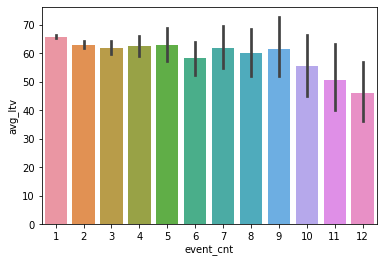

In [ ]:
sns.barplot(data=result_df,x='event_cnt',y='avg_ltv')

We can see that event_cnt has a total of 12 values. We can use this as a categorical feature Also, there is only one customer where the avg_ltv > 1000. 

Let us check if there are any relation between purchase event and avg_ltv

In [ ]:
query = f"""
SELECT
  user_pseudo_id,
  count(distinct ep.value.int_value) as purch_event_cnt,
  avg(ltv) as avg_ltv

  FROM 
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`,
  unnest (event_params) as ep
  where ep.key='ga_session_id' and event_name='purchase'
  group by user_pseudo_id
  order by user_pseudo_id;
  """
#print(query)
query_job = client.query(query)
result_df=query_job.to_dataframe()
result_df.head()

,user_pseudo_id,purch_event_cnt,avg_ltv
0,10092926.3786306416,1,6.250000
1,10111055.8768683862,1,3.133333
2,1014825.0200289249,1,8.854839
3,1016446.8237887674,1,14.489130
4,1019527.5799124267,1,1.039370


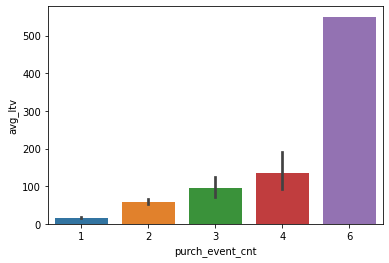

In [ ]:
sns.barplot(data=result_df,x='purch_event_cnt',y='avg_ltv')

We can see a relation that there is very high relation between purchase event_cnt as a categorical variable and avg_ltv

In [ ]:
query = f"""
SELECT
  user_pseudo_id,
  event_name,
  avg(ifnull(ep.value.int_value,0) + ifnull(ep.value.double_value,0)) as avg_purch_value,
  avg(ltv) as avg_ltv
  FROM 
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`,
  unnest (event_params) as ep
  where ep.key='value' and event_name='purchase'
  group by user_pseudo_id, event_name
  order by user_pseudo_id
  """
query_job = client.query(query)
result_df=query_job.to_dataframe()
result_df.head()



,user_pseudo_id,event_name,avg_purch_value,avg_ltv
0,10092926.3786306416,purchase,89.6,6.250000
1,10111055.8768683862,purchase,94.4,3.133333
2,1014825.0200289249,purchase,183.2,8.854839
3,1016446.8237887674,purchase,85.6,14.489130
4,1019527.5799124267,purchase,44.0,1.039370


In [ ]:
result_df.corr()

,avg_purch_value,avg_ltv
avg_purch_value,1.000000,0.301407
avg_ltv,0.301407,1.000000


We can see that there is 0.3 correlation between avg_purch_value and avg_ltv

In [9]:
query = f"""

CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.ga4_features_train AS
with tableA as
(SELECT
  user_pseudo_id,
  count(distinct ep.value.int_value) as event_cnt,
  avg(ltv) as avg_ltv
  FROM 
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`,
  unnest (event_params) as ep
  where ep.key='ga_session_id'
  group by user_pseudo_id),
  
tableB as
(SELECT
  user_pseudo_id,
  count(distinct ep.value.int_value) as purch_event_cnt
  FROM 
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`,
  unnest (event_params) as ep
  where ep.key='ga_session_id' and event_name='purchase'
  group by user_pseudo_id
  order by user_pseudo_id
),

tableC as
(SELECT
  user_pseudo_id,
  event_name,
  avg(ifnull(ep.value.int_value,0) + ifnull(ep.value.double_value,0)) as avg_purch_value
  FROM 
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`,
  unnest (event_params) as ep
  where ep.key='value' and event_name='purchase'
  group by user_pseudo_id, event_name
  order by user_pseudo_id
)
select a.*, 
ifnull(b.purch_event_cnt,0) as purch_event_cnt, 
ifnull(c.avg_purch_value,0) as avg_purch_value, 
from tableA as a

LEFT OUTER JOIN tableB b
on a.user_pseudo_id=b.user_pseudo_id

LEFT OUTER JOIN tableC c
on a.user_pseudo_id=c.user_pseudo_id
"""

print(query)
#query_job = client.query(query)



CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.ga4_features_train AS
with tableA as
(SELECT
  user_pseudo_id,
  count(distinct ep.value.int_value) as event_cnt,
  avg(ltv) as avg_ltv
  FROM 
  `mh-hackathon.ga4_data.ga4_train`,
  unnest (event_params) as ep
  where ep.key='ga_session_id'
  group by user_pseudo_id),
  
tableB as
(SELECT
  user_pseudo_id,
  count(distinct ep.value.int_value) as purch_event_cnt
  FROM 
  `mh-hackathon.ga4_data.ga4_train`,
  unnest (event_params) as ep
  where ep.key='ga_session_id' and event_name='purchase'
  group by user_pseudo_id
  order by user_pseudo_id
),

tableC as
(SELECT
  user_pseudo_id,
  event_name,
  avg(ifnull(ep.value.int_value,0) + ifnull(ep.value.double_value,0)) as avg_purch_value
  FROM 
  `mh-hackathon.ga4_data.ga4_train`,
  unnest (event_params) as ep
  where ep.key='value' and event_name='purchase'
  group by user_pseudo_id, event_name
  order by user_pseudo_id
)
select a.*, 
ifnull(b.purch_event_cnt,0) as purch_event_cnt, 
ifnull

# Base Model performance

In [ ]:
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table="ga4_features_train" #table name 

model_name = "base_model"

DATASET_NAME = "ga4_ecomm_feature_set"
feature_table="ga4_features_train" #table name 

model_name = "model_base"


model_query = f"""
CREATE OR REPLACE MODEL
  `{DATASET_NAME}.{model_name}`
  OPTIONS(MODEL_TYPE = 'RANDOM_FOREST_REGRESSOR',
         NUM_PARALLEL_TREE = 80,
         TREE_METHOD = 'AUTO',
         MIN_TREE_CHILD_WEIGHT = 1,
         MAX_TREE_DEPTH = 20,
         L1_REG = 0.1,
         L2_REG = 1.0,
         EARLY_STOP = FALSE,
         INPUT_LABEL_COLS = ['avg_ltv'],
         DATA_SPLIT_METHOD = 'AUTO_SPLIT'
) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `{PROJECT_ID}.{DATASET_NAME}.{feature_table}`
WHERE
  avg_ltv IS NOT NULL
"""
print(model_query)
# query_job = client.query(query)
#RUN THIS ON BQ CONSOLE 



CREATE OR REPLACE MODEL
  `ga4_ecomm_feature_set.model_base`
  OPTIONS(MODEL_TYPE = 'RANDOM_FOREST_REGRESSOR',
         NUM_PARALLEL_TREE = 80,
         TREE_METHOD = 'AUTO',
         MIN_TREE_CHILD_WEIGHT = 1,
         MAX_TREE_DEPTH = 20,
         L1_REG = 0.1,
         L2_REG = 1.0,
         EARLY_STOP = FALSE,
         INPUT_LABEL_COLS = ['avg_ltv'],
         DATA_SPLIT_METHOD = 'AUTO_SPLIT'
) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `mh-bq-hackathon-377815.ga4_ecomm_feature_set.ga4_features_train`
WHERE
  avg_ltv IS NOT NULL



In [ ]:
ml_evaluate_query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{DATASET_NAME}.{model_name}`,
    (
    SELECT
      *
    FROM
      `{PROJECT_ID}.{DATASET_NAME}.{feature_table}`
    WHERE
      avg_ltv IS NOT NULL))
"""
query_job = client.query(ml_evaluate_query)
ml_info_df = query_job.to_dataframe()
ml_info_df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,66.103434,10774.789165,2.533318,49.955143,0.003887,0.003887


Our baseline mean_squared error is **2.533318**. We will try to reduce it by first checking other features

## model v01

First we check whether every user_pesudo_id is having a single country

In [ ]:
query = f"""
SELECT 
user_pseudo_id,
count(distinct geo.country) as count,
FROM 
`{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
group by user_pseudo_id
order by count desc
  """
query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df

,user_pseudo_id,count
0,61031472.8710389493,1
1,8594243.4562718268,1
2,30900021.3233786964,1
3,63357346.9414125241,1
4,4536661.2797800413,1
...,...,...
243389,13231387.2841802492,1
243390,6830577.0389059589,1
243391,26540464.7147100862,1
243392,74483445.6936549499,1


As we see from the above dataframe, we have a single country for each user_id

In [ ]:
query = f"""

SELECT * FROM
  (SELECT 
    user_pseudo_id,
    geo.country as country, avg(ltv) as avg_ltv
    FROM 
    `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
    group by user_pseudo_id, geo.country
    order by user_pseudo_id
  )
where avg_ltv < 500
"""

query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df

,user_pseudo_id,country,avg_ltv
0,10001363.4360935308,Sweden,385.958107
1,1000223163.8035209215,Australia,104.976037
2,1000299.7413851356,India,9.005161
3,1000300.3223254235,France,28.117118
4,10004358.0897722689,Russia,481.587137
...,...,...,...
243379,9997317.3571391655,China,272.379965
243380,99974675.1893931687,Russia,19.020052
243381,9997700.2258881857,United States,34.642738
243382,99978280.9164065304,United States,416.485939


In [ ]:
temp=result_df.groupby('country').mean().sort_values('avg_ltv',ascending=False)
temp.head()

,avg_ltv
country,
Iceland,93.797867
Panama,86.922438
Mongolia,86.100464
Estonia,86.088314
Armenia,78.936548


In [ ]:
plt.figure(figsize=(12,4))
px.bar(temp,x=temp.index,y='avg_ltv')

<Figure size 864x288 with 0 Axes>

Since we see a trend here, we can use it for prediction as feature

In [ ]:
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table="ga4_features_train" #table name

query = f"""

CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.ga4_features_train AS
with tableA as
(SELECT
  user_pseudo_id,
  count(distinct ep.value.int_value) as event_cnt,
  geo.country as country,
  avg(ltv) as avg_ltv
  FROM 
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`,
  unnest (event_params) as ep
  where ep.key='ga_session_id'
  group by user_pseudo_id,country),
  
tableB as
(SELECT
  user_pseudo_id,
  count(distinct ep.value.int_value) as purch_event_cnt
  FROM 
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`,
  unnest (event_params) as ep
  where ep.key='ga_session_id' and event_name='purchase'
  group by user_pseudo_id
  order by user_pseudo_id
),

tableC as
(SELECT
  user_pseudo_id,
  event_name,
  avg(ifnull(ep.value.int_value,0) + ifnull(ep.value.double_value,0)) as avg_purch_value
  FROM 
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`,
  unnest (event_params) as ep
  where ep.key='value' and event_name='purchase'
  group by user_pseudo_id, event_name
  order by user_pseudo_id
)
select a.*, 
ifnull(b.purch_event_cnt,0) as purch_event_cnt, 
ifnull(c.avg_purch_value,0) as avg_purch_value, 
from tableA as a

LEFT OUTER JOIN tableB b
on a.user_pseudo_id=b.user_pseudo_id

LEFT OUTER JOIN tableC c
on a.user_pseudo_id=c.user_pseudo_id
"""

print(query)
#query_job = client.query(query)



CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.ga4_features_train AS
with tableA as
(SELECT
  user_pseudo_id,
  count(distinct ep.value.int_value) as event_cnt,
  geo.country as country,
  avg(ltv) as avg_ltv
  FROM 
  `mh-hackathon.ga4_data.ga4_train`,
  unnest (event_params) as ep
  where ep.key='ga_session_id'
  group by user_pseudo_id,country),
  
tableB as
(SELECT
  user_pseudo_id,
  count(distinct ep.value.int_value) as purch_event_cnt
  FROM 
  `mh-hackathon.ga4_data.ga4_train`,
  unnest (event_params) as ep
  where ep.key='ga_session_id' and event_name='purchase'
  group by user_pseudo_id
  order by user_pseudo_id
),

tableC as
(SELECT
  user_pseudo_id,
  event_name,
  avg(ifnull(ep.value.int_value,0) + ifnull(ep.value.double_value,0)) as avg_purch_value
  FROM 
  `mh-hackathon.ga4_data.ga4_train`,
  unnest (event_params) as ep
  where ep.key='value' and event_name='purchase'
  group by user_pseudo_id, event_name
  order by user_pseudo_id
)
select a.*, 
ifnull(b.purch_event_

In [ ]:
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table="ga4_features_train" #table name 

model_name = "model_v01"


model_query = f"""
CREATE OR REPLACE MODEL
  `{DATASET_NAME}.{model_name}`
  OPTIONS(MODEL_TYPE = 'RANDOM_FOREST_REGRESSOR',
         NUM_PARALLEL_TREE = 100,
         TREE_METHOD = 'AUTO',
         MIN_TREE_CHILD_WEIGHT = 1,
         MAX_TREE_DEPTH = 20,
         L1_REG = 0.1,
         L2_REG = 1.0,
         EARLY_STOP = FALSE,
         INPUT_LABEL_COLS = ['avg_ltv'],
         DATA_SPLIT_METHOD = 'AUTO_SPLIT'
) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `{PROJECT_ID}.{DATASET_NAME}.{feature_table}`
WHERE
  avg_ltv IS NOT NULL
"""
print(model_query)
# query_job = client.query(query)
#RUN THIS ON BQ CONSOLE 



CREATE OR REPLACE MODEL
  `ga4_ecomm_feature_set.model_v01`
  OPTIONS(MODEL_TYPE = 'RANDOM_FOREST_REGRESSOR',
         NUM_PARALLEL_TREE = 100,
         TREE_METHOD = 'AUTO',
         MIN_TREE_CHILD_WEIGHT = 1,
         MAX_TREE_DEPTH = 20,
         L1_REG = 0.1,
         L2_REG = 1.0,
         EARLY_STOP = FALSE,
         INPUT_LABEL_COLS = ['avg_ltv'],
         DATA_SPLIT_METHOD = 'AUTO_SPLIT'
) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `mh-bq-hackathon-377815.ga4_ecomm_feature_set.ga4_features_train`
WHERE
  avg_ltv IS NOT NULL



In [ ]:
ml_evaluate_query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{DATASET_NAME}.{model_name}`,
    (
    SELECT
      *
    FROM
      `{PROJECT_ID}.{DATASET_NAME}.{feature_table}`
    WHERE
      avg_ltv IS NOT NULL))
"""
query_job = client.query(ml_evaluate_query)
ml_info_df = query_job.to_dataframe()
ml_info_df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,66.06557,10757.905841,2.52714,49.927714,0.005448,0.005448


After adding country variable, we were able to reduce error from  **2.533318** 	to **2.52714**. Let us try boosted tree regressor with same feature table

In [ ]:
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table="ga4_features_train" #table name 

model_name = "model_v01_2"


model_query = f"""
CREATE OR REPLACE MODEL
  `{DATASET_NAME}.{model_name}` 
  OPTIONS (
      MODEL_TYPE = 'BOOSTED_TREE_REGRESSOR',
          NUM_PARALLEL_TREE = 40,
          TREE_METHOD = 'AUTO',
          MIN_TREE_CHILD_WEIGHT = 1,
          MAX_TREE_DEPTH = 20,
          L1_REG = 0.1,
          L2_REG = 1.0,
          LEARN_RATE = 0.1,
          EARLY_STOP = FALSE,
          INPUT_LABEL_COLS = ['avg_ltv'],
          MAX_ITERATIONS = 20,
          DATA_SPLIT_METHOD = 'AUTO_SPLIT',
          ENABLE_GLOBAL_EXPLAIN = TRUE
   ) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `{PROJECT_ID}.{DATASET_NAME}.{feature_table}`
WHERE
  avg_ltv IS NOT NULL
"""
print(model_query)
# query_job = client.query(linear_regression_query)
#RUN THIS ON BQ CONSOLE 


CREATE OR REPLACE MODEL
  `ga4_ecomm_feature_set.model_v01_2` 
  OPTIONS (
      MODEL_TYPE = 'BOOSTED_TREE_REGRESSOR',
          NUM_PARALLEL_TREE = 40,
          TREE_METHOD = 'AUTO',
          MIN_TREE_CHILD_WEIGHT = 1,
          MAX_TREE_DEPTH = 20,
          L1_REG = 0.1,
          L2_REG = 1.0,
          LEARN_RATE = 0.1,
          EARLY_STOP = FALSE,
          INPUT_LABEL_COLS = ['avg_ltv'],
          MAX_ITERATIONS = 20,
          DATA_SPLIT_METHOD = 'AUTO_SPLIT',
          ENABLE_GLOBAL_EXPLAIN = TRUE
   ) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `mh-bq-hackathon-377815.ga4_ecomm_feature_set.ga4_features_train`
WHERE
  avg_ltv IS NOT NULL



In [ ]:
ml_evaluate_query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{DATASET_NAME}.{model_name}`,
    (
    SELECT
      *
    FROM
      `{PROJECT_ID}.{DATASET_NAME}.{feature_table}`
    WHERE
      avg_ltv IS NOT NULL))
"""
query_job = client.query(ml_evaluate_query)
ml_info_df = query_job.to_dataframe()
ml_info_df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,62.488071,10815.967141,2.322254,42.252595,0.000081,0.005802


Using boosted regression with the same features as model_v01, we got a reduced log loss error of **2.322254**. Let us predict and see the performance in the test set submission

Model prediction:

In [ ]:
# Creating features from test set 
feature_table_test ="ga4_features_test" #table name
query = f"""

CREATE OR REPLACE TABLE
  {DATASET_NAME}.{feature_table_test} AS
with tableA as
(SELECT
  user_pseudo_id,
  count(distinct ep.value.int_value) as event_cnt,
  geo.country as country
  FROM 
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`,
  unnest (event_params) as ep
  where ep.key='ga_session_id'
  group by user_pseudo_id,country),
  
tableB as
(SELECT
  user_pseudo_id,
  count(distinct ep.value.int_value) as purch_event_cnt
  FROM 
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`,
  unnest (event_params) as ep
  where ep.key='ga_session_id' and event_name='purchase'
  group by user_pseudo_id
  order by user_pseudo_id
),

tableC as
(SELECT
  user_pseudo_id,
  event_name,
  avg(ifnull(ep.value.int_value,0) + ifnull(ep.value.double_value,0)) as avg_purch_value
  FROM 
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`,
  unnest (event_params) as ep
  where ep.key='value' and event_name='purchase'
  group by user_pseudo_id, event_name
  order by user_pseudo_id
)
select a.*, 
ifnull(b.purch_event_cnt,0) as purch_event_cnt, 
ifnull(c.avg_purch_value,0) as avg_purch_value, 
from tableA as a

LEFT OUTER JOIN tableB b
on a.user_pseudo_id=b.user_pseudo_id

LEFT OUTER JOIN tableC c
on a.user_pseudo_id=c.user_pseudo_id
"""

print(query)
#query_job = client.query(query)



CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.ga4_features_test AS
with tableA as
(SELECT
  user_pseudo_id,
  count(distinct ep.value.int_value) as event_cnt,
  geo.country as country
  FROM 
  `mh-hackathon.ga4_data.ga4_test`,
  unnest (event_params) as ep
  where ep.key='ga_session_id'
  group by user_pseudo_id,country),
  
tableB as
(SELECT
  user_pseudo_id,
  count(distinct ep.value.int_value) as purch_event_cnt
  FROM 
  `mh-hackathon.ga4_data.ga4_test`,
  unnest (event_params) as ep
  where ep.key='ga_session_id' and event_name='purchase'
  group by user_pseudo_id
  order by user_pseudo_id
),

tableC as
(SELECT
  user_pseudo_id,
  event_name,
  avg(ifnull(ep.value.int_value,0) + ifnull(ep.value.double_value,0)) as avg_purch_value
  FROM 
  `mh-hackathon.ga4_data.ga4_test`,
  unnest (event_params) as ep
  where ep.key='value' and event_name='purchase'
  group by user_pseudo_id, event_name
  order by user_pseudo_id
)
select a.*, 
ifnull(b.purch_event_cnt,0) as purch_event_cnt, 

In [ ]:
query = """

SELECT
  *
FROM
  `ga4_ecomm_feature_set.ga4_features_test`
LIMIT
5
"""
query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df.head()

,user_pseudo_id,event_cnt,country,purch_event_cnt,avg_purch_value
0,12048323.0241015083,1,Iraq,0,0.0
1,71913925.3660785960,1,Iraq,0,0.0
2,52930935.3361895591,1,Iraq,0,0.0
3,55666112.2535837096,1,Iraq,0,0.0
4,49169381.0292915254,1,Iraq,0,0.0


In [ ]:
prediction_data_table_name = "model_prediction_ltv_test"
query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{prediction_data_table_name} AS
SELECT
  *
FROM
  ML.PREDICT(MODEL `{DATASET_NAME}.{model_name}`,
    (
    SELECT
      *
    FROM
      `{PROJECT_ID}.{DATASET_NAME}.ga4_features_test`
    ))
"""
#print(query)
query_job = client.query(query)

In [ ]:
query = f"""
SELECT
  *
FROM
  {PROJECT_ID}.{DATASET_NAME}.{prediction_data_table_name}
LIMIT 5
"""
# print(query)
query_job = client.query(query)
predict_data = query_job.to_dataframe()
predict_data.head()

,predicted_avg_ltv,user_pseudo_id,event_cnt,country,purch_event_cnt,avg_purch_value
0,55.063293,52930935.3361895591,1,Iraq,0,0.0
1,55.063293,2233580.1409555663,1,Iraq,0,0.0
2,55.063293,7480762.7528452146,1,Iraq,0,0.0
3,55.063293,71913925.3660785960,1,Iraq,0,0.0
4,55.063293,12048323.0241015083,1,Iraq,0,0.0


In [ ]:
query = f"""
SELECT
  user_pseudo_id,predicted_avg_ltv
FROM
  {PROJECT_ID}.{DATASET_NAME}.{prediction_data_table_name}
"""
# print(query)
query_job = client.query(query)
submission_data = query_job.to_dataframe()
submission_data.head()

,user_pseudo_id,predicted_avg_ltv
0,52930935.3361895591,55.063293
1,2233580.1409555663,55.063293
2,7480762.7528452146,55.063293
3,71913925.3660785960,55.063293
4,12048323.0241015083,55.063293


In [ ]:
## Create Submission 
submission = submission_data[['user_pseudo_id',"predicted_avg_ltv"]]
submission.to_csv("submission.csv",index=False)

#make sure before submission that your shape is (26760, 2). Do not submit unless its of same shape. 
print(submission.shape)

submission.head()

(26760, 2)


,user_pseudo_id,predicted_avg_ltv
0,52930935.3361895591,55.063293
1,2233580.1409555663,55.063293
2,7480762.7528452146,55.063293
3,71913925.3660785960,55.063293
4,12048323.0241015083,55.063293


Let us now explore more possible features. Previous train error is **2.322254**. On submission, we got a test error of **2.02801**. 

Let us find the recency value for all customer.
1. find our recent/max purch date for each customer.  
2. Recency value = (Recent purchase date of total ds) - (Recent purch date of that customer)

In [ ]:
query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.recency_table AS
SELECT 
  user_pseudo_id,
  date_diff(ds_max_date, max_purch_date, day) as recency,
  avg_ltv
  FROM
    (SELECT
      user_pseudo_id,
      MAX(parse_date("%Y%m%d",event_date)) as max_purch_date,
      avg(ltv) as avg_ltv,
    (SELECT max(parse_date("%Y%m%d",event_date))
      FROM 
        `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`) as ds_max_date
      FROM `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
      group by user_pseudo_id)
    order by recency
"""

print(query)
#query_job = client.query(query)
#result_df=query_job.to_dataframe()
#result_df.head()


CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.recency_table AS
SELECT 
  user_pseudo_id,
  date_diff(ds_max_date, max_purch_date, day) as recency,
  avg_ltv
  FROM
    (SELECT
      user_pseudo_id,
      MAX(parse_date("%Y%m%d",event_date)) as max_purch_date,
      avg(ltv) as avg_ltv,
    (SELECT max(parse_date("%Y%m%d",event_date))
      FROM 
        `mh-hackathon.ga4_data.ga4_train`) as ds_max_date
      FROM `mh-hackathon.ga4_data.ga4_train`
      group by user_pseudo_id)
    order by recency



In [ ]:
query = f"""
SELECT
  *
FROM
  {PROJECT_ID}.{DATASET_NAME}.`recency_table`
"""
# print(query)
query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df.head()

,user_pseudo_id,recency,avg_ltv
0,49267832.2721884349,0,50.025329
1,4038731.3310220776,0,1.674628
2,25051995.6437331939,0,19.669898
3,4572202.1345566659,0,20.899581
4,81197365.0316199823,0,11.134586


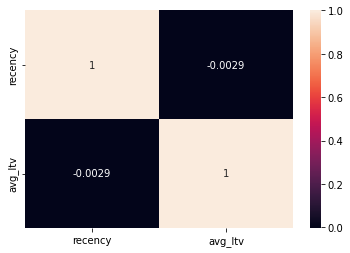

In [ ]:
sns.heatmap(result_df.corr(), annot=True)

In [ ]:
# Create tableA from model_v01_train

temp_data='model_v01_train'

query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{temp_data} AS

SELECT *
FROM
  `{DATASET_NAME}.{feature_table}`
  """
print(query)
#query_job = client.query(query)


CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.model_v01_train AS

SELECT *
FROM
  `ga4_ecomm_feature_set.ga4_features_train`
  


In [ ]:
#JOIN two tables
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table_2="ga4_features_train_2" #table name 

query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{feature_table_2} AS

SELECT a.*,b.recency from {DATASET_NAME}.{feature_table} as a
LEFT OUTER JOIN `ga4_ecomm_feature_set.recency_table` as b
on a.user_pseudo_id=b.user_pseudo_id
"""

print(query)
#query_job = client.query(query)


CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.ga4_features_train_2 AS

SELECT a.*,b.recency from ga4_ecomm_feature_set.ga4_features_train as a
LEFT OUTER JOIN `ga4_ecomm_feature_set.recency_table` as b
on a.user_pseudo_id=b.user_pseudo_id



In [ ]:
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table_2="ga4_features_train_2" #table name 

model_name = "model_v02_1"


model_query = f"""
CREATE OR REPLACE MODEL
  `{DATASET_NAME}.{model_name}` 
  OPTIONS (
      MODEL_TYPE = 'BOOSTED_TREE_REGRESSOR',
          NUM_PARALLEL_TREE = 20,
          TREE_METHOD = 'AUTO',
          MIN_TREE_CHILD_WEIGHT = 1,
          MAX_TREE_DEPTH = 20,
          L1_REG = 0.1,
          L2_REG = 1.0,
          LEARN_RATE = 0.1,
          EARLY_STOP = FALSE,
          INPUT_LABEL_COLS = ['avg_ltv'],
          MAX_ITERATIONS = 10,
          DATA_SPLIT_METHOD = 'AUTO_SPLIT',
          ENABLE_GLOBAL_EXPLAIN = TRUE
   ) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `{PROJECT_ID}.{DATASET_NAME}.{feature_table_2}`
WHERE
  avg_ltv IS NOT NULL
"""
print(model_query)
# query_job = client.query(query)
#RUN THIS ON BQ CONSOLE 



CREATE OR REPLACE MODEL
  `ga4_ecomm_feature_set.model_v02_1` 
  OPTIONS (
      MODEL_TYPE = 'BOOSTED_TREE_REGRESSOR',
          NUM_PARALLEL_TREE = 20,
          TREE_METHOD = 'AUTO',
          MIN_TREE_CHILD_WEIGHT = 1,
          MAX_TREE_DEPTH = 20,
          L1_REG = 0.1,
          L2_REG = 1.0,
          LEARN_RATE = 0.1,
          EARLY_STOP = FALSE,
          INPUT_LABEL_COLS = ['avg_ltv'],
          MAX_ITERATIONS = 10,
          DATA_SPLIT_METHOD = 'AUTO_SPLIT',
          ENABLE_GLOBAL_EXPLAIN = TRUE
   ) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `mh-bq-hackathon-377815.ga4_ecomm_feature_set.ga4_features_train_2`
WHERE
  avg_ltv IS NOT NULL



In [ ]:
# Previous train error is 2.322254
# model_v02 train error is 

ml_evaluate_query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{DATASET_NAME}.{model_name}`,
    (
    SELECT
      *
    FROM
      `{PROJECT_ID}.{DATASET_NAME}.{feature_table_2}`
    WHERE
      avg_ltv IS NOT NULL))
"""
query_job = client.query(ml_evaluate_query)
ml_info_df = query_job.to_dataframe()
ml_info_df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,57.166605,11233.866014,1.969231,31.243747,-0.038553,0.008823


Previous train error is **2.322254**. Now, we have reduced this error to **1.969231**

Model prediction:

In [ ]:
query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.recency_table_test AS
SELECT 
  user_pseudo_id,
  date_diff(ds_max_date, max_purch_date, day) as recency,
  FROM
    (SELECT
      user_pseudo_id,
      MAX(parse_date("%Y%m%d",event_date)) as max_purch_date,
    (SELECT max(parse_date("%Y%m%d",event_date))
      FROM 
        `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`) as ds_max_date
      FROM `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`
      group by user_pseudo_id)
    order by recency
"""

query_job = client.query(query)
result_df=query_job.to_dataframe()
result_df.head()

""


In [ ]:
# Create tableA from model_v01_test
feature_table_test ="ga4_features_test" #table name
temp_data='model_v01_test'

query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{temp_data} AS

SELECT *
FROM
  `{DATASET_NAME}.{feature_table_test}`
  """
print(query)
#query_job = client.query(query)


CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.model_v01_test AS

SELECT *
FROM
  `ga4_ecomm_feature_set.ga4_features_test`
  


In [ ]:
#JOIN two tables
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table_test_2 ="ga4_features_test_2"

query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{feature_table_test_2} AS

SELECT a.*,b.recency from {DATASET_NAME}.{feature_table_test} as a
LEFT OUTER JOIN `ga4_ecomm_feature_set.recency_table_test` as b
on a.user_pseudo_id=b.user_pseudo_id
"""

print(query)
#query_job = client.query(query)


CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.ga4_features_test_2 AS

SELECT a.*,b.recency from ga4_ecomm_feature_set.ga4_features_test as a
LEFT OUTER JOIN `ga4_ecomm_feature_set.recency_table_test` as b
on a.user_pseudo_id=b.user_pseudo_id



In [ ]:
query = """

SELECT
  *
FROM
  `ga4_ecomm_feature_set.ga4_features_test_2`
LIMIT
5
"""
query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df.head()

,user_pseudo_id,event_cnt,country,purch_event_cnt,avg_purch_value,recency
0,21504745.7735951005,1,Iraq,0,0.0,3
1,15702967.3527629514,4,Iraq,0,0.0,7
2,6687663.3517999807,4,Iraq,0,0.0,11
3,3064299603.0714928102,4,Iraq,0,0.0,11
4,7480762.7528452146,1,Iraq,0,0.0,15


In [ ]:
prediction_data_table_name = "model_prediction_ltv_test"
query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{prediction_data_table_name} AS
SELECT
  *
FROM
  ML.PREDICT(MODEL `{DATASET_NAME}.{model_name}`,
    (
    SELECT
      *
    FROM
      `{PROJECT_ID}.{DATASET_NAME}.ga4_features_test_2`
    ))
"""
#print(query)
query_job = client.query(query)

In [ ]:
query = f"""
SELECT
  *
FROM
  {PROJECT_ID}.{DATASET_NAME}.{prediction_data_table_name}
LIMIT 5
"""
# print(query)
query_job = client.query(query)
predict_data = query_job.to_dataframe()
predict_data.head()

,predicted_avg_ltv,user_pseudo_id,event_cnt,country,purch_event_cnt,avg_purch_value,recency
0,36.039948,73074756.5884503346,4,Belgium,0,0.00,0
1,26.965714,21683663.4440188892,5,India,2,19.92,0
2,42.955322,2149547.9104796436,3,Taiwan,0,0.00,0
3,42.955322,4992778.7263895978,3,United States,0,0.00,0
4,42.955322,6799714.2617049073,3,United States,0,0.00,0


In [ ]:
query = f"""
SELECT
  user_pseudo_id,predicted_avg_ltv
FROM
  {PROJECT_ID}.{DATASET_NAME}.{prediction_data_table_name}
"""
# print(query)
query_job = client.query(query)
submission_data = query_job.to_dataframe()
submission_data.head()

,user_pseudo_id,predicted_avg_ltv
0,73074756.5884503346,36.039948
1,21683663.4440188892,26.965714
2,2149547.9104796436,42.955322
3,4992778.7263895978,42.955322
4,6799714.2617049073,42.955322


In [ ]:
# if negative values present in target, change them to 0
submission_data.loc[submission_data['predicted_avg_ltv'] < 0,'predicted_avg_ltv']=0
#submission_data[submission_data['predicted_avg_ltv'] < 0]['predicted_avg_ltv']

In [ ]:
## Create Submission 
submission = submission_data[['user_pseudo_id',"predicted_avg_ltv"]]
submission.to_csv("submission.csv",index=False)

#make sure before submission that your shape is (26760, 2). Do not submit unless its of same shape. 
print(submission.shape)

submission.head()

(26760, 2)


,user_pseudo_id,predicted_avg_ltv
0,73074756.5884503346,36.039948
1,21683663.4440188892,26.965714
2,2149547.9104796436,42.955322
3,4992778.7263895978,42.955322
4,6799714.2617049073,42.955322


Let us now explore more possible features. Previous train error is **1.969231** and test error is **1.95673**

1. Purchase revenue
2. purchase_quantity



In [ ]:
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table="ga4_features_train" #table name

query = f"""
 SELECT
user_pseudo_id,event_name,
avg(IFNULL(ecommerce.purchase_revenue,0)) as avg_purch_rev, 
avg(IFNULL(ecommerce.total_item_quantity,0)) as avg_quantity,  
avg(ltv) as avg_ltv
  FROM 
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
  where event_name='purchase'
  group by user_pseudo_id, event_name  
"""
#print(query)
query_job = client.query(query)
result_df=query_job.to_dataframe()
result_df.head()

,user_pseudo_id,event_name,avg_purch_rev,avg_quantity,avg_ltv
0,1362228.4966015575,purchase,0.0,0.0,38.232682
1,73549247.9231269047,purchase,0.0,0.0,378.510474
2,8079006.6650182195,purchase,0.0,0.0,15.817262
3,59728514.6794390622,purchase,21.0,2.5,17.485714
4,62339222.8549151994,purchase,0.0,0.0,61.595250


In [ ]:
result_df.corr()

,avg_purch_rev,avg_quantity,avg_ltv
avg_purch_rev,1.000000,0.646085,0.173818
avg_quantity,0.646085,1.000000,0.104535
avg_ltv,0.173818,0.104535,1.000000


We can see that definitely there is high correlation between these 2 features and avg_ltv.

For now, let us first add only purch_rev due to high corr b/w quantity

## Train mode_v03_1

In [ ]:
# Create tableA from model_v02_train
feature_table_2="ga4_features_train_2" #table name 

temp_data='model_v02_train'

query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{temp_data} AS

SELECT *
FROM
  `{DATASET_NAME}.{feature_table_2}`
  """
print(query)
query_job = client.query(query)


CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.model_v02_train AS

SELECT *
FROM
  `ga4_ecomm_feature_set.ga4_features_train_2`
  


In [10]:
#JOIN two tables
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table_2="ga4_features_train_2" #table name 
feature_table_3="ga4_features_train_3" #table name 

query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{feature_table_3} AS

with tableB as
    (SELECT
    user_pseudo_id,event_name,
    avg(IFNULL(ecommerce.purchase_revenue,0)) as avg_purch_rev, 
    avg(IFNULL(ecommerce.total_item_quantity,0)) as avg_quantity,  
    avg(ltv) as avg_ltv
      FROM 
      `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
      where event_name='purchase'
      group by user_pseudo_id, event_name)

SELECT a.*,
IFNULL(b.avg_purch_rev,0) as avg_purch_rev  
from {DATASET_NAME}.{feature_table_2} as a
LEFT OUTER JOIN tableB as b
on a.user_pseudo_id=b.user_pseudo_id
"""

print(query)
#query_job = client.query(query)


CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.ga4_features_train_3 AS

with tableB as
    (SELECT
    user_pseudo_id,event_name,
    avg(IFNULL(ecommerce.purchase_revenue,0)) as avg_purch_rev, 
    avg(IFNULL(ecommerce.total_item_quantity,0)) as avg_quantity,  
    avg(ltv) as avg_ltv
      FROM 
      `mh-hackathon.ga4_data.ga4_train`
      where event_name='purchase'
      group by user_pseudo_id, event_name)

SELECT a.*,
IFNULL(b.avg_purch_rev,0) as avg_purch_rev  
from ga4_ecomm_feature_set.ga4_features_train_2 as a
LEFT OUTER JOIN tableB as b
on a.user_pseudo_id=b.user_pseudo_id



In [38]:
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table_3="ga4_features_train_3" #table name  

model_name = "model_v03_1"


model_query = f"""
CREATE OR REPLACE MODEL
  `{DATASET_NAME}.{model_name}` 
  OPTIONS (
      MODEL_TYPE = 'BOOSTED_TREE_REGRESSOR',
          NUM_PARALLEL_TREE = 10,
          TREE_METHOD = 'AUTO',
          MIN_TREE_CHILD_WEIGHT = 1,
          MAX_TREE_DEPTH = 20,
          L1_REG = 0.1,
          L2_REG = 1.0,
          LEARN_RATE = 0.1,
          EARLY_STOP = FALSE,
          INPUT_LABEL_COLS = ['avg_ltv'],
          MAX_ITERATIONS = 20,
          DATA_SPLIT_METHOD = 'AUTO_SPLIT',
          ENABLE_GLOBAL_EXPLAIN = TRUE
   ) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `{PROJECT_ID}.{DATASET_NAME}.{feature_table_3}`
WHERE
  avg_ltv IS NOT NULL
"""
print(model_query)
# query_job = client.query(query)
#RUN THIS ON BQ CONSOLE 



CREATE OR REPLACE MODEL
  `ga4_ecomm_feature_set.model_v03_1` 
  OPTIONS (
      MODEL_TYPE = 'BOOSTED_TREE_REGRESSOR',
          NUM_PARALLEL_TREE = 10,
          TREE_METHOD = 'AUTO',
          MIN_TREE_CHILD_WEIGHT = 1,
          MAX_TREE_DEPTH = 20,
          L1_REG = 0.1,
          L2_REG = 1.0,
          LEARN_RATE = 0.1,
          EARLY_STOP = FALSE,
          INPUT_LABEL_COLS = ['avg_ltv'],
          MAX_ITERATIONS = 20,
          DATA_SPLIT_METHOD = 'AUTO_SPLIT',
          ENABLE_GLOBAL_EXPLAIN = TRUE
   ) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `mh-bq-hackathon-377815.ga4_ecomm_feature_set.ga4_features_train_3`
WHERE
  avg_ltv IS NOT NULL



In [12]:
# Previous train error is 1.969231
# model_v03 train error is 1.914631

ml_evaluate_query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{DATASET_NAME}.{model_name}`,
    (
    SELECT
      *
    FROM
      `{PROJECT_ID}.{DATASET_NAME}.{feature_table_3}`
    WHERE
      avg_ltv IS NOT NULL))
"""
query_job = client.query(ml_evaluate_query)
ml_info_df = query_job.to_dataframe()
ml_info_df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,56.624066,11042.56559,1.914631,30.669127,-0.020868,0.027794


prediction:

In [13]:
# Create tableA from model_v02_test
feature_table_test_2 ="ga4_features_test_2"
temp_data='model_v02_test'

query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{temp_data} AS

SELECT *
FROM
  `{DATASET_NAME}.{feature_table_test_2}`
  """
print(query)
#query_job = client.query(query)


CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.model_v02_test AS

SELECT *
FROM
  `ga4_ecomm_feature_set.ga4_features_test_2`
  


In [14]:
#JOIN two tables
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table_test_3 ="ga4_features_test_3"

query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{feature_table_test_3} AS

with tableB as
    (SELECT
    user_pseudo_id,event_name,
    avg(IFNULL(ecommerce.purchase_revenue,0)) as avg_purch_rev, 
    avg(IFNULL(ecommerce.total_item_quantity,0)) as avg_quantity
      FROM 
      `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`
      where event_name='purchase'
      group by user_pseudo_id, event_name)

SELECT a.*,
IFNULL(b.avg_purch_rev,0) as avg_purch_rev  
from {DATASET_NAME}.{feature_table_test_2} as a
LEFT OUTER JOIN tableB as b
on a.user_pseudo_id=b.user_pseudo_id
"""

print(query)
#query_job = client.query(query)


CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.ga4_features_test_3 AS

with tableB as
    (SELECT
    user_pseudo_id,event_name,
    avg(IFNULL(ecommerce.purchase_revenue,0)) as avg_purch_rev, 
    avg(IFNULL(ecommerce.total_item_quantity,0)) as avg_quantity
      FROM 
      `mh-hackathon.ga4_data.ga4_test`
      where event_name='purchase'
      group by user_pseudo_id, event_name)

SELECT a.*,
IFNULL(b.avg_purch_rev,0) as avg_purch_rev  
from ga4_ecomm_feature_set.ga4_features_test_2 as a
LEFT OUTER JOIN tableB as b
on a.user_pseudo_id=b.user_pseudo_id



In [15]:
query = """

SELECT
  *
FROM
  `ga4_ecomm_feature_set.ga4_features_test_3`
LIMIT
5
"""
query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df.head()

,user_pseudo_id,event_cnt,country,purch_event_cnt,avg_purch_value,recency,avg_purch_rev
0,6063325642.9002756564,1,India,0,0.0,0,0.0
1,2540425.9025017966,1,India,0,0.0,0,0.0
2,13990887.8615933051,1,United States,0,0.0,0,0.0
3,68822055.7616719350,1,United States,0,0.0,0,0.0
4,4647124.0421280044,1,United States,0,0.0,0,0.0


In [39]:
prediction_data_table_name = "model_prediction_ltv_test"
query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{prediction_data_table_name} AS
SELECT
  *
FROM
  ML.PREDICT(MODEL `{DATASET_NAME}.{model_name}`,
    (
    SELECT
      *
    FROM
      `{PROJECT_ID}.{DATASET_NAME}.ga4_features_test_3`
    ))
"""
#print(query)
query_job = client.query(query)

In [40]:
query = f"""
SELECT
  *
FROM
  {PROJECT_ID}.{DATASET_NAME}.{prediction_data_table_name}
LIMIT 5
"""
# print(query)
query_job = client.query(query)
predict_data = query_job.to_dataframe()
predict_data.head()

,predicted_avg_ltv,user_pseudo_id,event_cnt,country,purch_event_cnt,avg_purch_value,recency,avg_purch_rev
0,48.531738,39415162.7249330678,1,Ireland,0,0.0,0,0.0
1,41.837738,22506825.8666788862,4,United States,0,0.0,0,0.0
2,41.837738,15272268.2621248841,4,United States,0,0.0,0,0.0
3,41.837738,10309845.4362790904,4,United States,0,0.0,0,0.0
4,41.837738,13098747.9132870870,4,United States,0,0.0,0,0.0


In [41]:
query = f"""
SELECT
  user_pseudo_id,predicted_avg_ltv
FROM
  {PROJECT_ID}.{DATASET_NAME}.{prediction_data_table_name}
"""
# print(query)
query_job = client.query(query)
submission_data = query_job.to_dataframe()
submission_data.head()

,user_pseudo_id,predicted_avg_ltv
0,39415162.7249330678,48.531738
1,22506825.8666788862,41.837738
2,15272268.2621248841,41.837738
3,10309845.4362790904,41.837738
4,13098747.9132870870,41.837738


In [42]:
# if negative values present in target, change them to 0
submission_data.loc[submission_data['predicted_avg_ltv'] < 0,'predicted_avg_ltv']
#submission_data[submission_data['predicted_avg_ltv'] < 0]['predicted_avg_ltv']

#No negative values found

Series([], Name: predicted_avg_ltv, dtype: float64)

In [43]:
## Create Submission 
submission = submission_data[['user_pseudo_id',"predicted_avg_ltv"]]
submission.to_csv("submission.csv",index=False)

#make sure before submission that your shape is (26760, 2). Do not submit unless its of same shape. 
print(submission.shape)

submission.head()

(26760, 2)


,user_pseudo_id,predicted_avg_ltv
0,39415162.7249330678,48.531738
1,22506825.8666788862,41.837738
2,15272268.2621248841,41.837738
3,10309845.4362790904,41.837738
4,13098747.9132870870,41.837738


It is showing that the test error is 1.97320 which means it is over-fitting. We have to do hyper-parameter tuning

In [30]:
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table_3="ga4_features_train_3" #table name  

model_name = "model_v03_hp"


model_query = f"""
CREATE OR REPLACE MODEL
  `{DATASET_NAME}.{model_name}`
  OPTIONS (MODEL_TYPE = 'BOOSTED_TREE_REGRESSOR',
          NUM_PARALLEL_TREE = HPARAM_RANGE(10,20),
          TREE_METHOD = 'AUTO',
          MIN_TREE_CHILD_WEIGHT = 1,
          MAX_TREE_DEPTH = HPARAM_RANGE(5,20),
          L1_REG = HPARAM_RANGE(0,1),
          L2_REG = HPARAM_RANGE(0,1),
          LEARN_RATE = 0.1,
          EARLY_STOP = FALSE,
          INPUT_LABEL_COLS = ['avg_ltv'],
          MAX_ITERATIONS = 20,
          DATA_SPLIT_METHOD = 'AUTO_SPLIT',
          ENABLE_GLOBAL_EXPLAIN = TRUE,
          NUM_TRIALS = 10,
          MAX_PARALLEL_TRIALS = 2,
          HPARAM_TUNING_OBJECTIVES = ['mean_squared_log_error']
) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `{PROJECT_ID}.{DATASET_NAME}.{feature_table_3}`
WHERE
  avg_ltv IS NOT NULL
"""
print(model_query)
# query_job = client.query(linear_regression_query)
#RUN THIS ON BQ CONSOLE 


CREATE OR REPLACE MODEL
  `ga4_ecomm_feature_set.model_v03_hp`
  OPTIONS (MODEL_TYPE = 'BOOSTED_TREE_REGRESSOR',
          NUM_PARALLEL_TREE = HPARAM_RANGE(10,20),
          TREE_METHOD = 'AUTO',
          MIN_TREE_CHILD_WEIGHT = 1,
          MAX_TREE_DEPTH = HPARAM_RANGE(5,20),
          L1_REG = HPARAM_RANGE(0,1),
          L2_REG = HPARAM_RANGE(0,1),
          LEARN_RATE = 0.1,
          EARLY_STOP = FALSE,
          INPUT_LABEL_COLS = ['avg_ltv'],
          MAX_ITERATIONS = 20,
          DATA_SPLIT_METHOD = 'AUTO_SPLIT',
          ENABLE_GLOBAL_EXPLAIN = TRUE,
          NUM_TRIALS = 10,
          MAX_PARALLEL_TRIALS = 2,
          HPARAM_TUNING_OBJECTIVES = ['mean_squared_log_error']
) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `mh-bq-hackathon-377815.ga4_ecomm_feature_set.ga4_features_train_3`
WHERE
  avg_ltv IS NOT NULL



In [31]:
query= f"""
SELECT *
FROM
  ML.TRIAL_INFO(MODEL `{DATASET_NAME}.{model_name}`)

"""
#print(query)

query_job = client.query(query)
ml_info_df = query_job.to_dataframe()
ml_info_df.head()

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'l1_reg': 1e-14, 'l2_reg': 1.0, 'max_tree_dep...",{'mean_squared_log_error': 1.9862916002631825},106.425,106.056,SUCCEEDED,None,True
1,2,"{'l1_reg': 9.27259701286398e-12, 'l2_reg': 0.0...",{'mean_squared_log_error': 1.9917661038802577},106.154,106.188,SUCCEEDED,None,False
2,3,"{'l1_reg': 1.3676205816429399e-11, 'l2_reg': 1...",{'mean_squared_log_error': 1.9866515976442458},106.448,106.060,SUCCEEDED,None,False
3,4,"{'l1_reg': 1e-14, 'l2_reg': 1.0, 'max_tree_dep...",{'mean_squared_log_error': 1.9866520439705195},106.448,106.060,SUCCEEDED,None,False
4,5,"{'l1_reg': 1.0001231714161332e-14, 'l2_reg': 0...",{'mean_squared_log_error': 1.9889346017295682},106.237,106.120,SUCCEEDED,None,False


In [32]:
ml_info_df[ml_info_df['is_optimal']==True]['hyperparameters'].values

array([{'l1_reg': 1e-14, 'l2_reg': 1.0, 'max_tree_depth': 6, 'num_parallel_tree': 10},
       {'l1_reg': 2.8048887174533613e-07, 'l2_reg': 1.0, 'max_tree_depth': 6, 'num_parallel_tree': 10}],
      dtype=object)

In [35]:
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table_3="ga4_features_train_3" #table name  

model_name = "model_v03_tuned"


model_query = f"""
CREATE OR REPLACE MODEL
  `{DATASET_NAME}.{model_name}`
  OPTIONS (MODEL_TYPE = 'BOOSTED_TREE_REGRESSOR',
          NUM_PARALLEL_TREE = 10,
          TREE_METHOD = 'AUTO',
          MIN_TREE_CHILD_WEIGHT = 1,
          MAX_TREE_DEPTH = 6,
          L1_REG = 0,
          L2_REG = 1,
          LEARN_RATE = 0.1,
          EARLY_STOP = FALSE,
          INPUT_LABEL_COLS = ['avg_ltv'],
          MAX_ITERATIONS = 20,
          DATA_SPLIT_METHOD = 'AUTO_SPLIT',
          ENABLE_GLOBAL_EXPLAIN = TRUE
) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `{PROJECT_ID}.{DATASET_NAME}.{feature_table_3}`
WHERE
  avg_ltv IS NOT NULL
"""
print(model_query)
# query_job = client.query(linear_regression_query)
#RUN THIS ON BQ CONSOLE 


CREATE OR REPLACE MODEL
  `ga4_ecomm_feature_set.model_v03_tuned`
  OPTIONS (MODEL_TYPE = 'BOOSTED_TREE_REGRESSOR',
          NUM_PARALLEL_TREE = 10,
          TREE_METHOD = 'AUTO',
          MIN_TREE_CHILD_WEIGHT = 1,
          MAX_TREE_DEPTH = 6,
          L1_REG = 0,
          L2_REG = 1,
          LEARN_RATE = 0.1,
          EARLY_STOP = FALSE,
          INPUT_LABEL_COLS = ['avg_ltv'],
          MAX_ITERATIONS = 20,
          DATA_SPLIT_METHOD = 'AUTO_SPLIT',
          ENABLE_GLOBAL_EXPLAIN = TRUE
) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `mh-bq-hackathon-377815.ga4_ecomm_feature_set.ga4_features_train_3`
WHERE
  avg_ltv IS NOT NULL



In [36]:
# Previous train error is 1.914631
# model_v03_tuned train error is 2.324798

ml_evaluate_query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{DATASET_NAME}.{model_name}`,
    (
    SELECT
      *
    FROM
      `{PROJECT_ID}.{DATASET_NAME}.{feature_table_3}`
    WHERE
      avg_ltv IS NOT NULL))
"""
query_job = client.query(ml_evaluate_query)
ml_info_df = query_job.to_dataframe()
ml_info_df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,62.502895,10824.557756,2.324798,42.252012,-0.000714,0.005015


## Model_v04_1

With purch_quantity

Let us add purch_quantity also and train model_v04_1

In [27]:
#JOIN two tables
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table_2="ga4_features_train_2" #table name 
feature_table_4="ga4_features_train_4" #table name 

query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{feature_table_4} AS

with tableB as
    (SELECT
    user_pseudo_id,event_name,
    avg(IFNULL(ecommerce.purchase_revenue,0)) as avg_purch_rev, 
    avg(IFNULL(ecommerce.total_item_quantity,0)) as avg_quantity,  
    avg(ltv) as avg_ltv
      FROM 
      `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
      where event_name='purchase'
      group by user_pseudo_id, event_name)

SELECT a.*,
IFNULL(b.avg_purch_rev,0) as avg_purch_rev,
IFNULL(b.avg_quantity,0) as avg_quantity  
from {DATASET_NAME}.{feature_table_2} as a
LEFT OUTER JOIN tableB as b
on a.user_pseudo_id=b.user_pseudo_id
"""

print(query)
#query_job = client.query(query)


CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.ga4_features_train_4 AS

with tableB as
    (SELECT
    user_pseudo_id,event_name,
    avg(IFNULL(ecommerce.purchase_revenue,0)) as avg_purch_rev, 
    avg(IFNULL(ecommerce.total_item_quantity,0)) as avg_quantity,  
    avg(ltv) as avg_ltv
      FROM 
      `mh-hackathon.ga4_data.ga4_train`
      where event_name='purchase'
      group by user_pseudo_id, event_name)

SELECT a.*,
IFNULL(b.avg_purch_rev,0) as avg_purch_rev,
IFNULL(b.avg_quantity,0) as avg_quantity  
from ga4_ecomm_feature_set.ga4_features_train_2 as a
LEFT OUTER JOIN tableB as b
on a.user_pseudo_id=b.user_pseudo_id



In [44]:
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table_4="ga4_features_train_4" #table name  

model_name = "model_v04_1"


model_query = f"""
CREATE OR REPLACE MODEL
  `{DATASET_NAME}.{model_name}`
  OPTIONS (MODEL_TYPE = 'BOOSTED_TREE_REGRESSOR',
          NUM_PARALLEL_TREE = 10,
          TREE_METHOD = 'AUTO',
          MIN_TREE_CHILD_WEIGHT = 1,
          MAX_TREE_DEPTH = 20,
          L1_REG = 0.1,
          L2_REG = 1.0,
          LEARN_RATE = 0.1,
          EARLY_STOP = FALSE,
          INPUT_LABEL_COLS = ['avg_ltv'],
          MAX_ITERATIONS = 20,
          DATA_SPLIT_METHOD = 'AUTO_SPLIT',
          ENABLE_GLOBAL_EXPLAIN = TRUE
) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `{PROJECT_ID}.{DATASET_NAME}.{feature_table_4}`
WHERE
  avg_ltv IS NOT NULL
"""
print(model_query)
# query_job = client.query(linear_regression_query)
#RUN THIS ON BQ CONSOLE 


CREATE OR REPLACE MODEL
  `ga4_ecomm_feature_set.model_v04_1`
  OPTIONS (MODEL_TYPE = 'BOOSTED_TREE_REGRESSOR',
          NUM_PARALLEL_TREE = 10,
          TREE_METHOD = 'AUTO',
          MIN_TREE_CHILD_WEIGHT = 1,
          MAX_TREE_DEPTH = 20,
          L1_REG = 0.1,
          L2_REG = 1.0,
          LEARN_RATE = 0.1,
          EARLY_STOP = FALSE,
          INPUT_LABEL_COLS = ['avg_ltv'],
          MAX_ITERATIONS = 20,
          DATA_SPLIT_METHOD = 'AUTO_SPLIT',
          ENABLE_GLOBAL_EXPLAIN = TRUE
) 
AS
SELECT
  * except (user_pseudo_id)
FROM
  `mh-bq-hackathon-377815.ga4_ecomm_feature_set.ga4_features_train_4`
WHERE
  avg_ltv IS NOT NULL



In [ ]:
# Previous train error is 1.914631
# model_v03 train error is 1.914631

ml_evaluate_query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{DATASET_NAME}.{model_name}`,
    (
    SELECT
      *
    FROM
      `{PROJECT_ID}.{DATASET_NAME}.{feature_table_4}`
    WHERE
      avg_ltv IS NOT NULL))
"""
query_job = client.query(ml_evaluate_query)
ml_info_df = query_job.to_dataframe()
ml_info_df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,56.624066,11042.56559,1.914631,30.669127,-0.020868,0.027794


Let us check test for model 4

In [29]:
#JOIN two tables
DATASET_NAME = "ga4_ecomm_feature_set"
feature_table_test_4 ="ga4_features_test_4"

query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{feature_table_test_4} AS

with tableB as
    (SELECT
    user_pseudo_id,event_name,
    avg(IFNULL(ecommerce.purchase_revenue,0)) as avg_purch_rev, 
    avg(IFNULL(ecommerce.total_item_quantity,0)) as avg_quantity
      FROM 
      `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`
      where event_name='purchase'
      group by user_pseudo_id, event_name)

SELECT a.*,
IFNULL(b.avg_purch_rev,0) as avg_purch_rev,
IFNULL(b.avg_quantity,0) as avg_quantity  
from {DATASET_NAME}.{feature_table_test_2} as a
LEFT OUTER JOIN tableB as b
on a.user_pseudo_id=b.user_pseudo_id
"""

print(query)
#query_job = client.query(query)


CREATE OR REPLACE TABLE
  ga4_ecomm_feature_set.ga4_features_test_4 AS

with tableB as
    (SELECT
    user_pseudo_id,event_name,
    avg(IFNULL(ecommerce.purchase_revenue,0)) as avg_purch_rev, 
    avg(IFNULL(ecommerce.total_item_quantity,0)) as avg_quantity
      FROM 
      `mh-hackathon.ga4_data.ga4_test`
      where event_name='purchase'
      group by user_pseudo_id, event_name)

SELECT a.*,
IFNULL(b.avg_purch_rev,0) as avg_purch_rev,
IFNULL(b.avg_quantity,0) as avg_quantity  
from ga4_ecomm_feature_set.ga4_features_test_2 as a
LEFT OUTER JOIN tableB as b
on a.user_pseudo_id=b.user_pseudo_id



In [ ]:
query = """

SELECT
  *
FROM
  `ga4_ecomm_feature_set.ga4_features_test_4`
LIMIT
5
"""
query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df.head()

,user_pseudo_id,event_cnt,country,purch_event_cnt,avg_purch_value,recency,avg_purch_rev
0,6063325642.9002756564,1,India,0,0.0,0,0.0
1,2540425.9025017966,1,India,0,0.0,0,0.0
2,13990887.8615933051,1,United States,0,0.0,0,0.0
3,68822055.7616719350,1,United States,0,0.0,0,0.0
4,4647124.0421280044,1,United States,0,0.0,0,0.0


In [ ]:
prediction_data_table_name = "model_prediction_ltv_test"
query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{prediction_data_table_name} AS
SELECT
  *
FROM
  ML.PREDICT(MODEL `{DATASET_NAME}.{model_name}`,
    (
    SELECT
      *
    FROM
      `{PROJECT_ID}.{DATASET_NAME}.ga4_features_test_4`
    ))
"""
#print(query)
query_job = client.query(query)

In [ ]:
query = f"""
SELECT
  *
FROM
  {PROJECT_ID}.{DATASET_NAME}.{prediction_data_table_name}
LIMIT 5
"""
# print(query)
query_job = client.query(query)
predict_data = query_job.to_dataframe()
predict_data.head()

,predicted_avg_ltv,user_pseudo_id,event_cnt,country,purch_event_cnt,avg_purch_value,recency,avg_purch_rev
0,48.531738,39415162.7249330678,1,Ireland,0,0.0,0,0.0
1,41.837738,10309845.4362790904,4,United States,0,0.0,0,0.0
2,41.837738,13098747.9132870870,4,United States,0,0.0,0,0.0
3,41.837738,89248523.8050408969,4,United States,0,0.0,0,0.0
4,41.837738,15272268.2621248841,4,United States,0,0.0,0,0.0


In [ ]:
query = f"""
SELECT
  user_pseudo_id,predicted_avg_ltv
FROM
  {PROJECT_ID}.{DATASET_NAME}.{prediction_data_table_name}
"""
# print(query)
query_job = client.query(query)
submission_data = query_job.to_dataframe()
submission_data.head()

,user_pseudo_id,predicted_avg_ltv
0,39415162.7249330678,48.531738
1,89248523.8050408969,41.837738
2,15272268.2621248841,41.837738
3,10309845.4362790904,41.837738
4,13098747.9132870870,41.837738


In [ ]:
# if negative values present in target, change them to 0
submission_data.loc[submission_data['predicted_avg_ltv'] < 0,'predicted_avg_ltv']
#submission_data[submission_data['predicted_avg_ltv'] < 0]['predicted_avg_ltv']

#No negative values found

Series([], Name: predicted_avg_ltv, dtype: float64)

In [ ]:
## Create Submission 
submission = submission_data[['user_pseudo_id',"predicted_avg_ltv"]]
submission.to_csv("submission.csv",index=False)

#make sure before submission that your shape is (26760, 2). Do not submit unless its of same shape. 
print(submission.shape)

submission.head()

(26760, 2)


,user_pseudo_id,predicted_avg_ltv
0,39415162.7249330678,48.531738
1,89248523.8050408969,41.837738
2,15272268.2621248841,41.837738
3,10309845.4362790904,41.837738
4,13098747.9132870870,41.837738


# Summary-

- **Client Lifetime Value, also known as Lifetime Value (LTV) and Customer Lifetime Value (CLV)**, is an important measure used in marketing to indicate an estimate of the net profit that would result from a real future connection with a customer
- In EDA, we can observe that there are roughly 4 million events with close to 270,000 users, stretched along 92 days of activity on the platform. 
- For simplicity, we will **assume that all user_pseudo_id are unique and represent a single user**.
- Final prediction dataset should have average LTV grouped by User pseudo ID. 
- **Base model:** 
    - High correlation between purchase event_cnt as a categorical variable and avg_ltv which is the target variable. 
    - Only event_cnt used to build the base model. Our baseline mean_squared error is 2.533318. We will try to reduce it by first checking other features
- **Model_v01**
    - We have a single country for each user_id. After adding country variable, we were able to reduce error from 2.533318 to 2.52714. Let us try boosted tree regressor with same feature table
    - Using boosted regression with the same features as model_v01, we got a reduced log loss error of 2.322254. Let us predict and see the performance in the test set . On submission, we got a test error of 2.02801.
- **model_v02_1**
    - Let us find the recency value for all customer: find our recent/max purch date for each customer. Recency value = (Recent purchase date of total ds) - (Recent purch date of that customer)
    - Train error is reduced to 1.969231
- **model_v03_1:**
    - Two new features: Purchase revenue, purchase_quantity
    - model_v03 train error is 1.914631
    - It is showing that the test error is 1.97320 which means it is over-fitting. We have to do hyper-parameter tuning. After tuning, we found no improvement. Hence dropping this model and moving on
- **Model_v04_1:**
    - With purch_quantity
    - Train error- 1.914631. we are finalizing this model.
    - **Final predictors:**
        - **user_pseudo_id**
        - **event_cnt**
        - **country**	
        - **purch_event_cnt**	
        - **avg_purch_value**	
        - **recency**	
        - **avg_purch_rev**
    - **This model on submission gave a test score of 1.95649 on final test dataset.**

